In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

print("Import done!")

Global seed set to 0


Import done!


In [2]:
#defining where we save the results
results_folder = './results/SSP_analysis/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [3]:
# Read h5ad single-cell data
adata_ref = sc.read_h5ad('./data/SSP_integrated/SSP_integrated_June2022.h5ad')
adata_ref

/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 15097 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nUMI', 'nGene', 'log10GenesPerUMI', 'sample', 'mtUMI', 'mitoRatio', 'status', 'age', 'sex', 'OperatedSide', 'OperatedType', 'OperativeIndication', 'Region', 'RNA_snn_res.0.3', 'seurat_clusters'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'hgnc_symbols'
    uns: 'neighbors'
    obsm: 'X_harmony', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'HARMONY', 'PCs'
    obsp: 'distances'

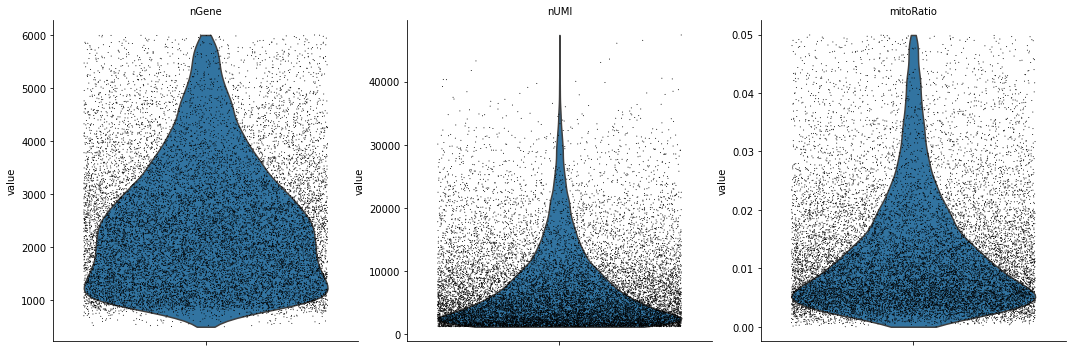

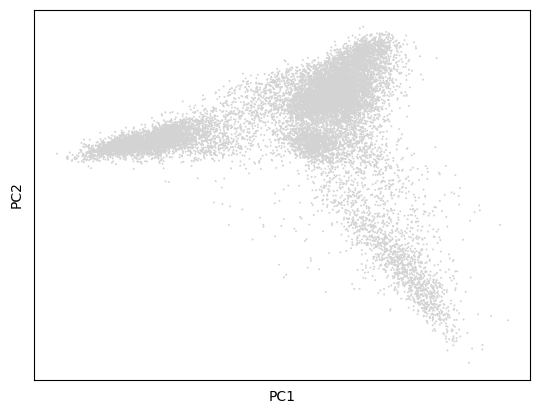

In [4]:
sc.pl.violin(adata_ref, ['nGene', 'nUMI', 'mitoRatio'],
             jitter=0.4, multi_panel=True)
sc.pl.pca(adata_ref)

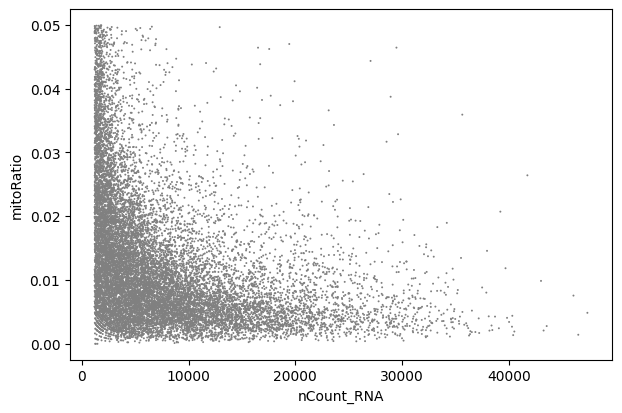

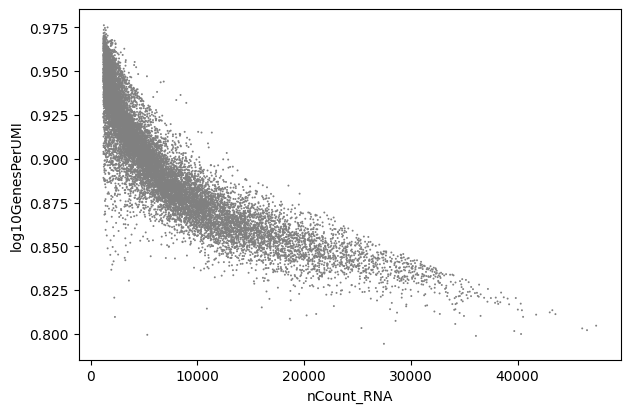

In [5]:
sc.pl.scatter(adata_ref, x='nCount_RNA', y='mitoRatio')
sc.pl.scatter(adata_ref, x='nCount_RNA', y='log10GenesPerUMI')

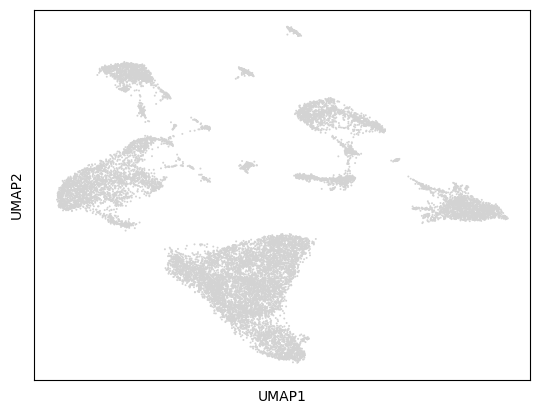

In [18]:
sc.pl.umap(adata_ref)

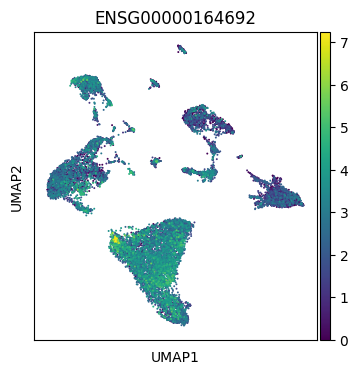

In [20]:
from matplotlib.pyplot import rc_context
# rc_context is used for the figure size, in this case 4x4
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata_ref, color='ENSG00000164692') #COL1A2

In [3]:
#loading visium data
adata_vis = sc.read_visium("./data//Ham1/", count_file='filtered_feature_bc_matrix.h5')
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]
adata_vis

/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2981 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

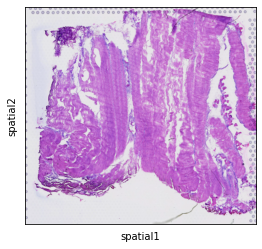

In [4]:
sc.pl.spatial(adata=adata_vis)

In [5]:
#renaming genes to ensembleids
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var.set_index('gene_ids', drop=True, inplace=True)
adata_vis

AnnData object with n_obs × n_vars = 2981 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'sample'
    var: 'feature_types', 'genome', 'SYMBOL'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


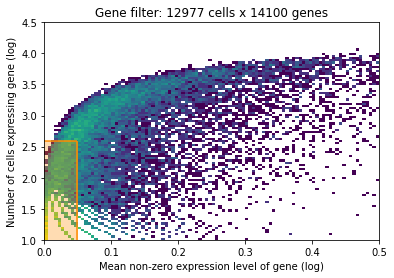

In [9]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [11]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='seurat_clusters'
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        # categorical_covariate_keys=['Method']
                       )

In [12]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.2.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': 'seurat_clusters',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 12977 │
│          n_vars          │ 14100 │
│         n_batch          │   4   │
│         n_labels         │  16   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ Hamstring0 │          0          │
│                     │ Hamstring1 │          1          │
│                     │ Hamstring2 │          2          │
│                     │ Hamstring5 │          3          │
└─────────────────────┴────────────┴─────────────────────┘

                       labels State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['seurat_clusters'] │     0      │          0          │
│                              │     1      │          1          │
│                              │     2      │          2          │
│                              │     3      │          3          │
│                              │     4      │          4          │
│                              │     5      │          5          │
│                              │     6      │          6          │
│                              │     7      │          7          │
│                              │     8      │          8          │
│                              │     9      │          9          │
│                              │     10     │         10          │
│                              │     11     │         11          │
│                              │     12     │         12          │
│                              │     13     │         13          │
│                              │     14     │         14          │
│                              │     15     │         15          │
└──────────────────────────────┴────────────┴─────────────────────┘

In [13]:
mod.train(max_epochs=250, use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/250:   0%|                                                                                      | 0/250 [00:00<?, ?it/s]

/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/torch/distributions/gamma.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /opt/lramosmu/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  self.rate * value - torch.lgamma(self.concentration))


Epoch 250/250: 100%|█████████████████████████████████████████████| 250/250 [03:51<00:00,  1.08it/s, v_num=1, elbo_train=7.32e+7]


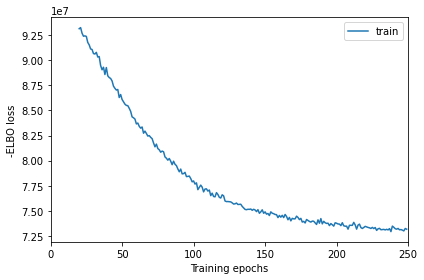

In [14]:
mod.plot_history(20)

In [15]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample: 100%|█████████████████████████████████████████████████████| 999/999 [00:06<00:00, 154.19it/s]


'./results/hamstring_analysis//reference_signatures/sc.h5ad'

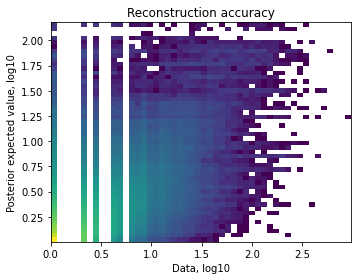

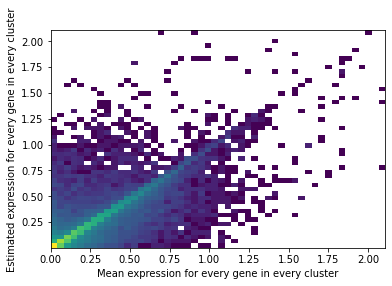

In [16]:
mod.plot_QC()

In [17]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

0         1         2         3         4
ENSG00000001460  0.033474  0.021775  0.031826  0.020875  0.018915
ENSG00000001461  0.050061  0.008456  0.011698  0.017885  0.046714
ENSG00000010072  0.033009  0.034393  0.047593  0.046801  0.029948
ENSG00000009780  0.179389  0.126138  0.168596  0.131229  0.113941
ENSG00000048707  0.961764  1.626855  1.943131  1.683035  0.758468

In [18]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [19]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 2981  │
│          n_vars          │ 13433 │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    Ham1    │          0          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 30000/30000: 100%|█████████████████████████████████████| 30000/30000 [32:02<00:00, 15.60it/s, v_num=1, elbo_train=1.72e+6]


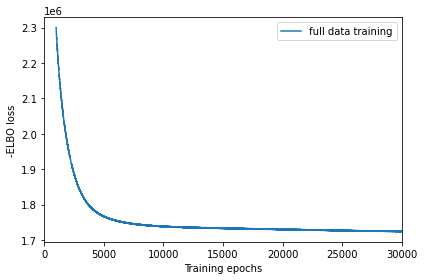

In [20]:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [21]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████████████████████████████████████████████████| 999/999 [00:12<00:00, 82.92it/s]


'./results/hamstring_analysis//cell2location_map/sp.h5ad'

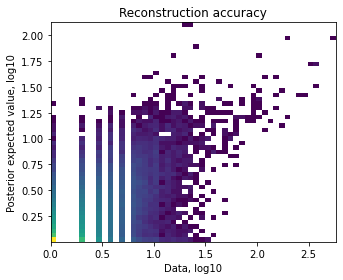

In [22]:
mod.plot_QC()

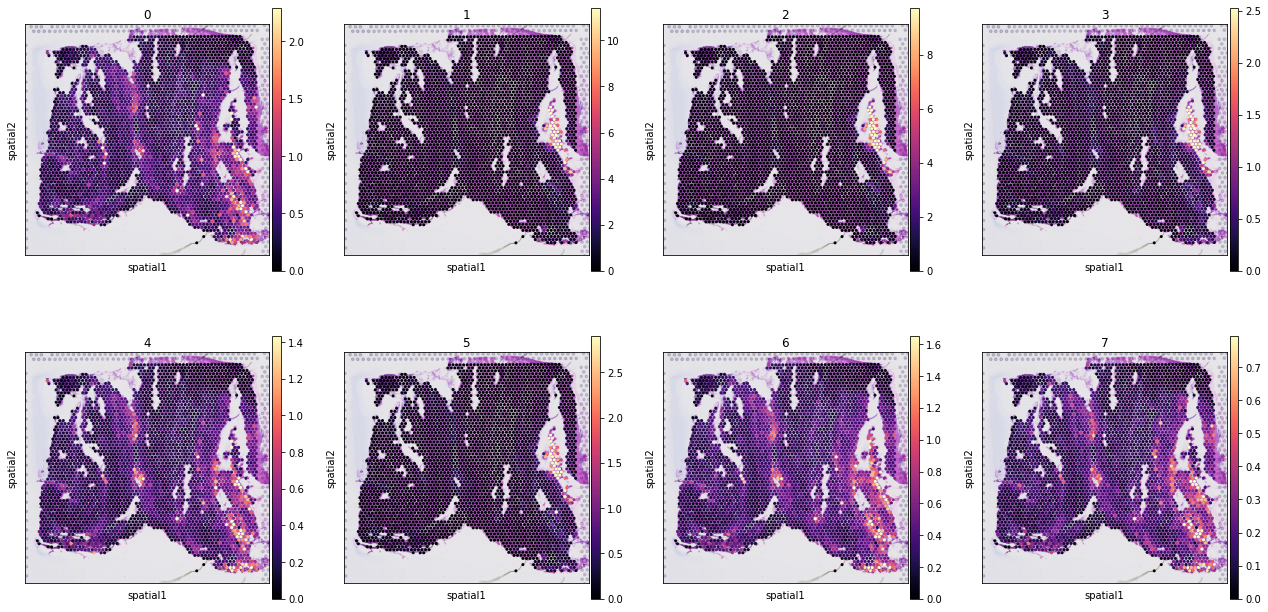

In [24]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, 'Ham1')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['0', '1', '2', '3',
                         '4', '5', '6', '7'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

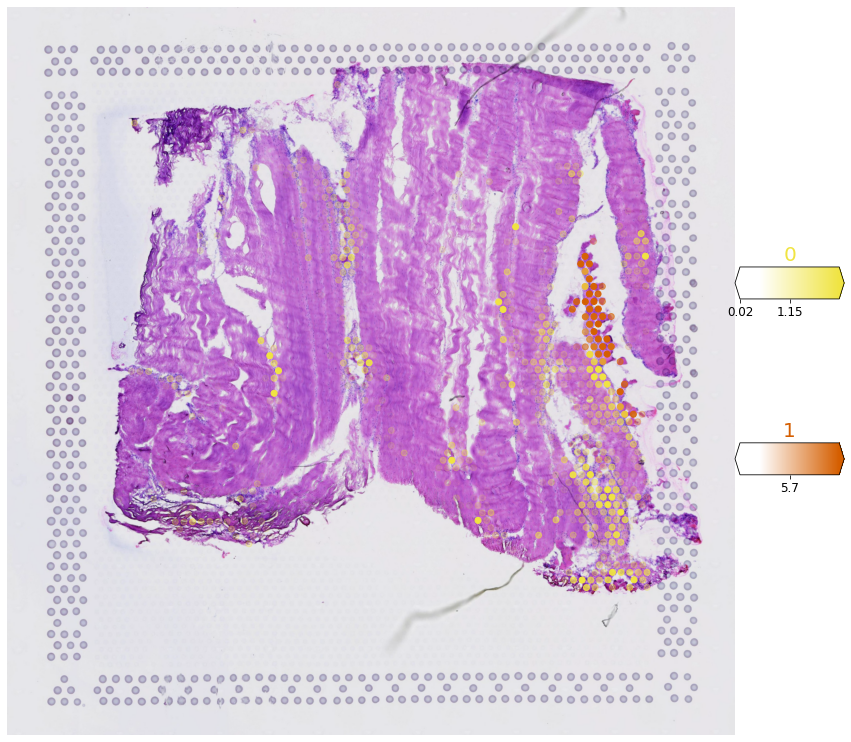

In [30]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['0', '1']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata_vis, 'Ham1')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )

In [26]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


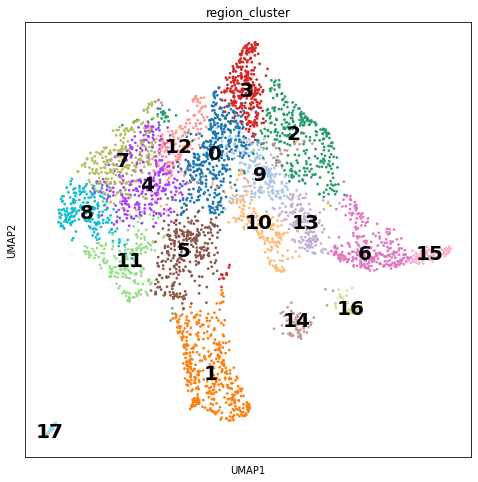

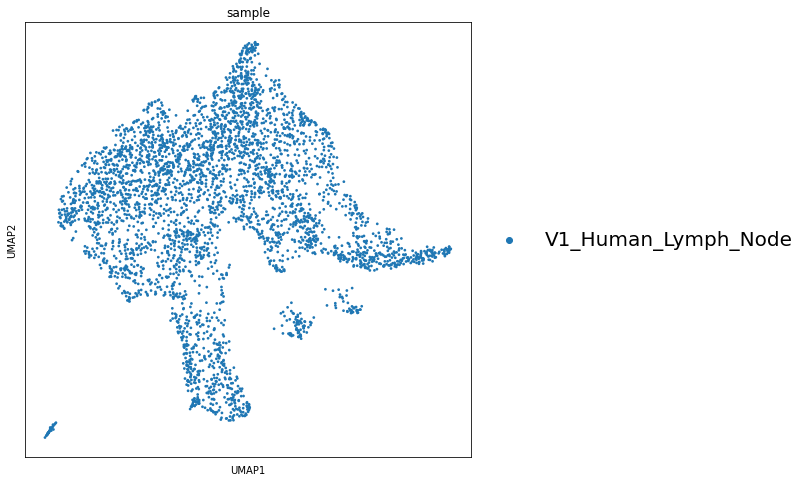

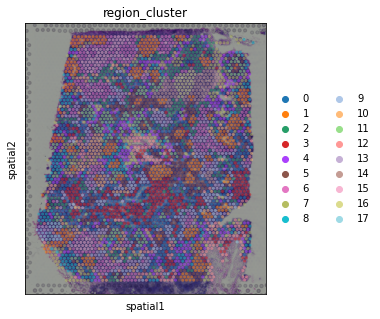

In [27]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    sc.pl.umap(adata_vis, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5)

In [28]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(11, 13), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    export_args={'path': f'{run_name}/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_4035locations_34factors


/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_4035locations_34factors


/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


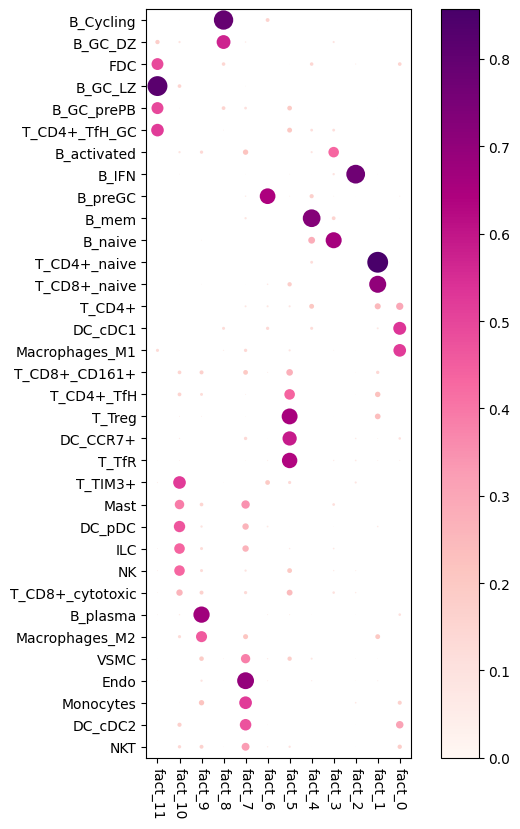

In [29]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
res_dict['n_fact12']['mod'].plot_cell_type_loadings()

In [30]:
# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata_manager
)

# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    adata_vis.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

'./results/lymph_nodes_analysis//cell2location_map/sp.h5ad'

In [31]:
# list cell types and genes for plotting
ctypes = ['T_CD4+_TfH_GC', 'T_CD4+_naive', 'B_GC_LZ']
genes = ['CD3D', 'CR2']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

    from tutorial_utils import plot_genes_per_cell_type
    plot_genes_per_cell_type(slide, genes, ctypes);

ModuleNotFoundError: No module named 'tutorial_utils'